# Libraries

In [1]:
import os
os.chdir('C:/Users/msali/Desktop/Python/water-pinns/src')  # Provide the new path here
#os.chdir('/leonardo_scratch/fast/IscrC_DL4STP/water-pinns/src')

In [2]:
from datetime import datetime

In [40]:
from operator import itemgetter
from tqdm import tqdm
import time
from datetime import datetime
import json
from collections import deque
import copy

import numpy as np
import pandas as pd
import geopandas as gpd
import xarray
import rioxarray
import fiona

#import matplotlib
import matplotlib.pyplot as plt

#from rasterio.enums import Resampling

import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SequentialSampler
from torch.utils.data.sampler import RandomSampler
import torch.nn as nn
from torch.autograd import Variable

import wandb

import torchview
from torchview import draw_graph

from utils.plot import *
import importlib

import seaborn as sns

In [4]:
from dataloaders import dataset_ST_MultiPoint
# from dataloaders import load_dataset
# from loss import losses_SparseData
# from models import models_SparseData
# from optimizer import load_optimizer

from subprocess import Popen

In [37]:
save_dir = "C:/Users/msali/Desktop/Python/water-pinns/results"
save_plot_dir = save_dir+"/plot"
save_ts_dir = save_plot_dir + "/ts" 

# Load dictionary

In [6]:
json_file = "C:/Users/msali/Desktop/Python/water-pinns/config/ST_MultiPoint/ST_MultiPoint_STDisNet_SAGW_PI_ERA5_local.json" #config_files_1d/lstm_att_1.json
#json_file = "/leonardo_scratch/fast/IscrC_DL4STP/water-pinns/config/ST_MultiPoint/ST_MultiPoint_STDisNet_SAGW_PI_ERA5.json" #config_files_1d/lstm_att_1.json
dict_files = {}
with open(json_file) as f:
    dict_files = json.load(f)
    print(f"Read data.json: {dict_files}")

Read data.json: {'cuda_device': 'cuda:0', 'seed': 42, 'entity': 'gsartor-unito', 'experiment_name': 'ST_MultiPoint', 'run_name': 'PI_S_ref', 'comments': None, 'wandb_mode': 'offline', 'wandb_dir': 'C:/Users/msali/Desktop/Python/water-pinns/results/results_ST_MultiPoint/logs', 'save_model_dir': 'C:/Users/msali/Desktop/Python/water-pinns/results/results_ST_MultiPoint/runs', 'dtm_nc': 'C:/Users/msali/Desktop/Python/water-pinns/data/dtm_ROI.nc', 'weather_nc_path': 'C:/Users/msali/Desktop/Python/water-pinns/data/era5land_2000_2024_weekly.nc', 'weather_dtm': 'C:/Users/msali/Desktop/Python/water-pinns/data/era5land_dtm.nc', 'wtd_csv_path': 'C:/Users/msali/Desktop/Python/water-pinns/data/dataset_wtd_roi.csv', 'wtd_shp': 'C:/Users/msali/Desktop/Python/water-pinns/data/shapefile/underground_wtd_sensor_roi.shp', 'piedmont_shp': 'C:/Users/msali/Desktop/Python/water-pinns/data/shapefile/piemonte_admin_boundaries.shp', 'recharge_areas_shp': 'C:/Users/msali/Desktop/Python/water-pinns/data/shapefile/A

# Dataset class

In [7]:
importlib.reload(dataset_ST_MultiPoint)

<module 'dataloaders.dataset_ST_MultiPoint' from 'C:\\Users\\msali\\Desktop\\Python\\water-pinns\\src\\dataloaders\\dataset_ST_MultiPoint.py'>

In [8]:
ds = dataset_ST_MultiPoint.Dataset_ST_MultiPoint(dict_files)

    Loading weather data... Done!
    Loading dtm... Done!
    Loading Piedmont Shapefiles... 

C:\Users\msali\Desktop\Python\water-pinns\src\dataloaders\dataset_ST_MultiPoint.py:101: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  clipped_buffer = clipped.buffer(buffer_recharge)


Done!
    Loading underground water data... Done!
    Norm factors:
{'target_means': np.float64(297.1249160768408), 'target_stds': 73.38987997145819, 'dtm_mean': <xarray.DataArray '__xarray_dataarray_variable__' ()> Size: 4B
array(1139.4907, dtype=float32)
Coordinates:
    spatial_ref  int64 8B 0, 'dtm_std': <xarray.DataArray '__xarray_dataarray_variable__' ()> Size: 8B
array(884.42437744)
Coordinates:
    spatial_ref  int64 8B 0, 'lat_mean': np.float64(44.800499999999964), 'lat_std': np.float64(0.3169655454549103), 'lon_mean': np.float64(7.375499999999998), 'lon_std': np.float64(0.4326943495034695), 'weather_mean': <xarray.Dataset> Size: 24B
Dimensions:      ()
Coordinates:
    spatial_ref  int64 8B 0
Data variables:
    tp           float32 4B 0.001774
    t2m          float32 4B 280.5
    pev          float32 4B -0.001865
    smlt         float32 4B 0.000512, 'weather_std': <xarray.Dataset> Size: 40B
Dimensions:      ()
Coordinates:
    spatial_ref  int64 8B 0
Data variables:
    tp

In [9]:
ds.lagged_df

h       lat       lon    height   doy_sin  \
date       sensor_id                                                       
2001-03-18 00103510001  0.708742  0.092573 -0.154837 -0.867314  0.969178   
           00104110001       NaN  0.244253  0.092673 -0.951665  0.969178   
           00105110001       NaN  0.492360  0.515847 -1.021644  0.969178   
           00105910001 -0.885893  0.190429  0.804935 -1.019226  0.969178   
           00105910002       NaN  0.275844  0.719558 -1.028665  0.969178   
...                          ...       ...       ...       ...       ...   
2023-12-24 00417910001 -0.614138 -0.087850  0.722069 -0.997676 -0.136906   
           00421510001  0.213099 -0.487574  0.639993 -0.930317 -0.136906   
           00421710001 -0.209684 -0.349954  0.444199 -0.962435 -0.136906   
           00422510001  1.751913 -0.890702  0.362317 -0.777576 -0.136906   
           00425010001  1.129672 -0.726844  0.461141 -0.853104 -0.136906   

                         doy_cos  doy_sin_lag1  doy_cos_lag1  \
date       sensor_id                                           
2001-03-18 00103510001  0.246361      0.932655      0.360771   
           00104110001  0.246361      0.932655      0.360771   
           00105110001  0.246361      0.932655      0.360771   
           00105910001  0.246361      0.932655      0.360771   
           00105910002  0.246361      0.932655      0.360771   
...                          ...           ...           ...   
2023-12-24 00417910001  0.990584     -0.254671      0.967028   
           00421510001  0.990584     -0.254671      0.967028   
           00421710001  0.990584     -0.254671      0.967028   
           00422510001  0.990584     -0.254671      0.967028   
           00425010001  0.990584     -0.254671      0.967028   

                        00103510001_lag1  00104110001_lag1  ...  \
date       sensor_id                                        ...   
2001-03-18 00103510001          0.707452               NaN  ...   
           00104110001          0.707452               NaN  ...   
           00105110001          0.707452               NaN  ...   
           00105910001          0.707452               NaN  ...   
           00105910002          0.707452               NaN  ...   
...                                  ...               ...  ...   
2023-12-24 00417910001          0.678984         -0.326637  ...   
           00421510001          0.678984         -0.326637  ...   
           00421710001          0.678984         -0.326637  ...   
           00422510001          0.678984         -0.326637  ...   
           00425010001          0.678984         -0.326637  ...   

                        00407810001_lag4  00408910001_lag4  00408910002_lag4  \
date       sensor_id                                                           
2001-03-18 00103510001          2.448618          0.740262               NaN   
           00104110001          2.448618          0.740262               NaN   
           00105110001          2.448618          0.740262               NaN   
           00105910001          2.448618          0.740262               NaN   
           00105910002          2.448618          0.740262               NaN   
...                                  ...               ...               ...   
2023-12-24 00417910001          2.430755               NaN          1.377348   
           00421510001          2.430755               NaN          1.377348   
           00421710001          2.430755               NaN          1.377348   
           00422510001          2.430755               NaN          1.377348   
           00425010001          2.430755               NaN          1.377348   

                        00414310002_lag4  00417910001_lag4  00421510001_lag4  \
date       sensor_id                                                           
2001-03-18 00103510001               NaN         -0.605031          0.216565   
           00104110001               NaN         -0.6050

# Maps

In [10]:
import matplotlib
# Colormap
import cmasher as cmr
# Automatic labeling
import adjustText as aT
# define box and geometry object
import shapely
from shapely.geometry import box

# Map plot
import pygmt

In [11]:
# Italy shp
italy_shp = gpd.read_file("C:/Users/msali/Desktop/Python/water-pinns/data/shapefile/Italy_Reg01012024_g_WGS84.shp", engine='fiona')
italy_shp = italy_shp.to_crs('epsg:4326')

In [12]:
# extract Province names and coord, useful for plots
provinces_names = [ds.piemonte_shp["nome"][i] for i in range(0,len(ds.piemonte_shp))]
provinces_long = [ds.piemonte_shp["geometry"][i].representative_point().coords[0][0] for i in range(0,len(ds.piemonte_shp))]
provinces_lat = [ds.piemonte_shp["geometry"][i].representative_point().coords[0][1] for i in range(0,len(ds.piemonte_shp))]
provinces_lat[-3] = provinces_lat[-3] - 0.25
provinces_long[-3] = provinces_long[-3] - 0.05

In [13]:
# Piedmont DTM (precise border)
piemonte_dtm = rioxarray.open_rasterio("C:/Users/msali/Desktop/Python/water-pinns/data/DTMPiemonte_filled_50m.tif", engine='fiona')
piemonte_dtm = piemonte_dtm.rio.reproject("epsg:4326")
piemonte_dtm = piemonte_dtm.where(piemonte_dtm != -99999) # Take valid pixel

In [14]:
# Load river shp
rivers_shp_100 = gpd.read_file("C:/Users/msali/Desktop/Python/water-pinns/data/shapefile/idro100-fiumi.shp", engine='fiona')
rivers_shp_100 = rivers_shp_100.to_crs('epsg:4326')

In [15]:
roi_box = [ds.dtm_roi.x.min().values,
        ds.dtm_roi.x.max().values,
        ds.dtm_roi.y.min().values,
        ds.dtm_roi.y.max().values]

In [16]:
roi_box = box(ds.dtm_roi.x.min().values, ds.dtm_roi.y.min().values, ds.dtm_roi.x.max().values, ds.dtm_roi.y.max().values)

In [50]:
# Compute sensor norm factors
denorm_target = copy.deepcopy(ds.wtd_df[ds.target])
denorm_target = (denorm_target * ds.norm_factors["target_stds"])+ds.norm_factors["target_means"]


target_means = denorm_target.groupby(level=1).transform('mean').values
target_means = target_means.reshape(len(ds.wtd_df.index)//len(ds.sensor_id_list),
                                    len(ds.sensor_id_list))[0,:] 


target_stds = denorm_target.groupby(level=1).transform('std').values
target_stds = target_stds.reshape(len(ds.wtd_df.index)//len(ds.sensor_id_list),
                                    len(ds.sensor_id_list))[0,:]

In [52]:
ds.wtd_geodf["means"] = target_means
ds.wtd_geodf["stds"] = target_stds

[]

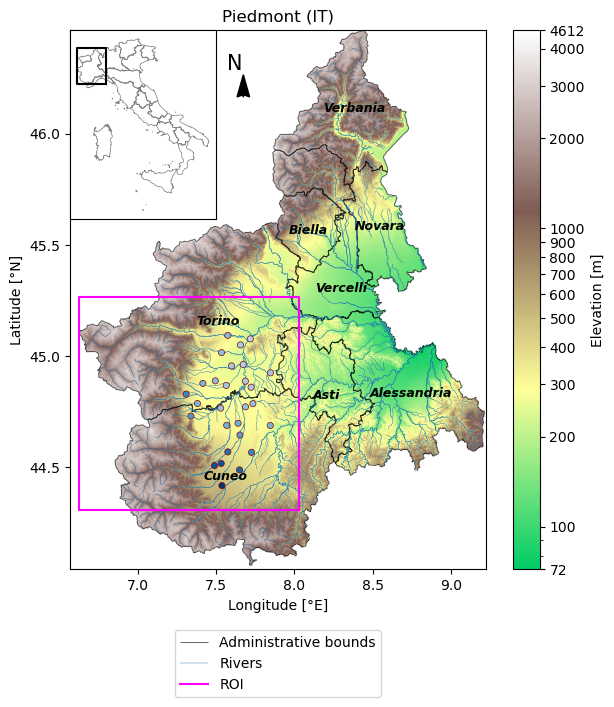

In [ ]:
fig, ax = plt.subplots(figsize = (7,7))

# Log-Scale: Define the ticks
cnorm = matplotlib.colors.LogNorm(vmin=piemonte_dtm.min(), vmax=piemonte_dtm.max())
decades = np.ceil(np.log10(cnorm.vmax / cnorm.vmin))
formatter = matplotlib.ticker.LogFormatter(10, minor_thresholds=(decades, decades))

# Plot with lognorm transformation
piemonte_elevation = piemonte_dtm.plot(ax = ax, add_colorbar=False,
                                      cmap = cmr.get_sub_cmap(plt.cm.terrain, 0.25,1),
                                      norm = matplotlib.colors.LogNorm(vmin = piemonte_dtm.min().values,
                                                                       vmax = piemonte_dtm.max().values))
ax.set_title("Piedmont (IT)")
ax.set_xlabel("Longitude [°E]")
ax.set_ylabel("Latitude [°N]")

# Regional shapefile
ds.piemonte_shp.boundary.plot(color = 'Black', linewidth = 0.7, alpha = 0.6, ax = ax, label = "Administrative bounds")

# Rivers
rivers_shp_100.loc[rivers_shp_100["CLASSE"] == 1].plot(ax = ax, linewidth=0.3, label = "Rivers")

# Provinces labels
texts = []
for x, y, label in zip(provinces_long, provinces_lat, provinces_names):

    texts.append(plt.text(x,y,label, ha='center', va='center' ,
                          fontsize =9, fontweight = "bold", fontstyle = "italic", color = "Black"))

    aT.adjust_text(texts, force_text =(0.1, 0.1), force_explode=(0, 0), #, min_arrow_len = 5
                       force_static =(0, 0),
                       arrowprops=dict(arrowstyle="simple", linestyle = "--", color='dimgrey', lw=1.2))
    
# ROI box
ax.plot(*roi_box.exterior.xy, label = "ROI", color = "magenta")

# Italy Inset
#inset_object = [italy_borders, Piemonte_box.exterior.xy]
piemonte_long_min, piemonte_lat_min, piemonte_long_max, piemonte_lat_max = ds.piemonte_shp.total_bounds
piemonte_box = box(piemonte_long_min, piemonte_lat_min, piemonte_long_max , piemonte_lat_max)

box(piemonte_long_min, piemonte_lat_min, piemonte_long_max , piemonte_lat_max)
axins = ax.inset_axes(bounds = [0,0.65,0.35,0.35])
italy_shp.boundary.plot(ax = axins, color = 'gray', linewidth = 0.5) # Italy
axins.plot(*piemonte_box.exterior.xy, color = "black") # Piemonte
axins.set_xticks([])
axins.set_yticks([])

# Sensors

gw_points = ax.scatter(
    ds.wtd_geodf.geometry.x, ds.wtd_geodf.geometry.y,
    marker="o",
    c=ds.wtd_geodf['means'],
    cmap=cmr.get_sub_cmap(plt.cm.Blues, 0.3,1),
    edgecolor='darkred',
    linewidths = 0.5,
    zorder = 1000,
    s=20)

plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.25))

# Colorbar for DTM
ticks = [cnorm.vmin, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 2000, 3000, 4000]
ticks.append(cnorm.vmax)
fig.colorbar(ticks=ticks, mappable=piemonte_elevation,
                  format = formatter, label = "Elevation [m]")

## North arrow
north_x_shift = 1.05
north_y_shift = -0.18
north_fontsize = 15
arrow_dx = 0
arrow_dy = 0.1
arrow_x_shift = 1.105
arrow_y_shift = -0.3
arrow_head_width=0.08
arrow_head_length=0.1
ax.text(x=ax.get_xlim()[0]+north_x_shift-0.05, y=ax.get_ylim()[1]+north_y_shift, s='N', fontsize=north_fontsize)
ax.arrow(ax.get_xlim()[0]+arrow_x_shift, ax.get_ylim()[1]+arrow_y_shift, arrow_dx, arrow_dy, length_includes_head=True,
         head_width=arrow_head_width, head_length=arrow_head_length, overhang=.1, facecolor='k')

#plt.savefig(f"{save_plot_dir}/piemonte.png", dpi = 400, transparent = True, bbox_inches = 'tight')

plt.plot()

## Crop

In [19]:
piemonte_dtm_clipped = piemonte_dtm.rio.clip_box(ds.dtm_roi.x.min().values,
        ds.dtm_roi.y.min().values,
        ds.dtm_roi.x.max().values,
        ds.dtm_roi.y.max().values)

In [20]:
# Approximate coordinates (lon, lat) for the cities
city_coords = {
    "Torino": (7.6867, 45.0706, (0,0.02)),
    "Cuneo": (7.5427, 44.3845, (0,-0.05)),
    "Carmagnola": (7.7203, 44.8496, (0.15,-0.04)),
    "Bra": (7.8500, 44.7000, (0.05,0)),
    "Savigliano": (7.6330, 44.6500, (0.125,-0.045)),
    "Susa": (7.0484, 45.1385, (0,0.02)),
    "Pinerolo": (7.3333, 44.8833, (0,0.02)),
    "Racconigi": (7.6740, 44.7687, (0,-0.045)),
    "Saluzzo": (7.4920, 44.6478, (0,-0.05)),
    "Fossano": (7.7194, 44.5503, (0.02,-0.045))
}

[]

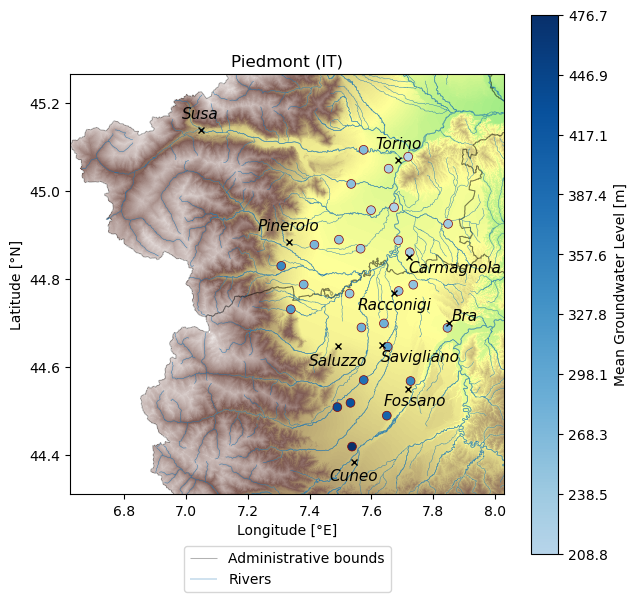

In [ ]:
fig, ax = plt.subplots(figsize = (7,7))

# Plot with lognorm transformation
piemonte_elevation = piemonte_dtm_clipped.plot(ax = ax, add_colorbar=False,
                                      cmap = cmr.get_sub_cmap(plt.cm.terrain, 0.25,1),
                                      norm = matplotlib.colors.LogNorm(vmin = piemonte_dtm.min().values,
                                                                       vmax = piemonte_dtm.max().values))
ax.set_title("Piedmont (IT)")
ax.set_xlabel("Longitude [°E]")
ax.set_ylabel("Latitude [°N]")

# Regional shapefile
ds.piemonte_shp.boundary.plot(color = 'Black', linewidth = 0.75, alpha = 0.3, ax = ax, label = "Administrative bounds")

# Rivers
rivers_shp_100.loc[rivers_shp_100["CLASSE"] == 1].plot(ax = ax, linewidth=0.3, label = "Rivers")

# City Labels
for city, (lon, lat,(dx,dy)) in city_coords.items():
    ax.plot(lon, lat, marker="x", color='black', markersize=4, zorder=2000)  # add point
    ax.text(lon + dx, lat + dy, city, fontsize=11,
        ha='center',
        va='bottom',
        fontstyle = "italic",
        color='black', zorder=2000)

# Sensors
gw_points = ax.scatter(
    ds.wtd_geodf.geometry.x, ds.wtd_geodf.geometry.y,
    marker="o",
    c=ds.wtd_geodf['means'],
    cmap=cmr.get_sub_cmap(plt.cm.Blues, 0.3,1),
    edgecolor='darkred',
    linewidths = 0.5,
    zorder = 1000,
    s=40)

plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.25))

# Colorbar for points
ticks_h = np.linspace(ds.wtd_geodf['means'].min(), ds.wtd_geodf['means'].max(),10)
plt.colorbar(mappable = gw_points, ticks= ticks_h, label = "Mean Groundwater Level [m]")

#plt.savefig(f"{save_plot_dir}/roi_piemonte.png", dpi = 400, transparent = True, bbox_inches = 'tight')

plt.plot()

[]

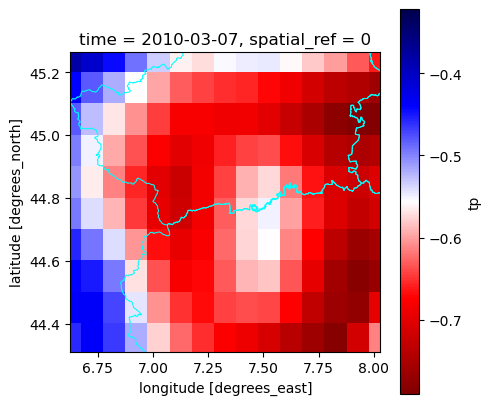

In [53]:
fig, ax = plt.subplots(figsize = (5,5))

ax.set_title("Piedmont (IT)")
ax.set_xlabel("Longitude [°E]")
ax.set_ylabel("Latitude [°N]")

# Regional shapefile
ds.piemonte_shp.boundary.plot(color = 'cyan', linewidth = 0.75, alpha = 1, ax = ax, label = "Administrative bounds")


# weather
ds.weather_xr["tp"][480].plot(ax = ax, cmap = "seismic_r")

# # Sensors
# gw_points = ax.scatter(
#     ds.wtd_geodf.geometry.x, ds.wtd_geodf.geometry.y,
#     marker="o",
#     color = "tab:blue",
#     edgecolor='black',
#     linewidths = 0.5,
#     zorder = 1000,
#     s=40)
        
plt.xlim((ds.dtm_roi.x.min().values,ds.dtm_roi.x.max().values))
plt.ylim((ds.dtm_roi.y.min().values,ds.dtm_roi.y.max().values))

#plt.savefig(f"{save_plot_dir}/roi_piemonte.png", dpi = 400, transparent = True, bbox_inches = 'tight')

plt.plot()

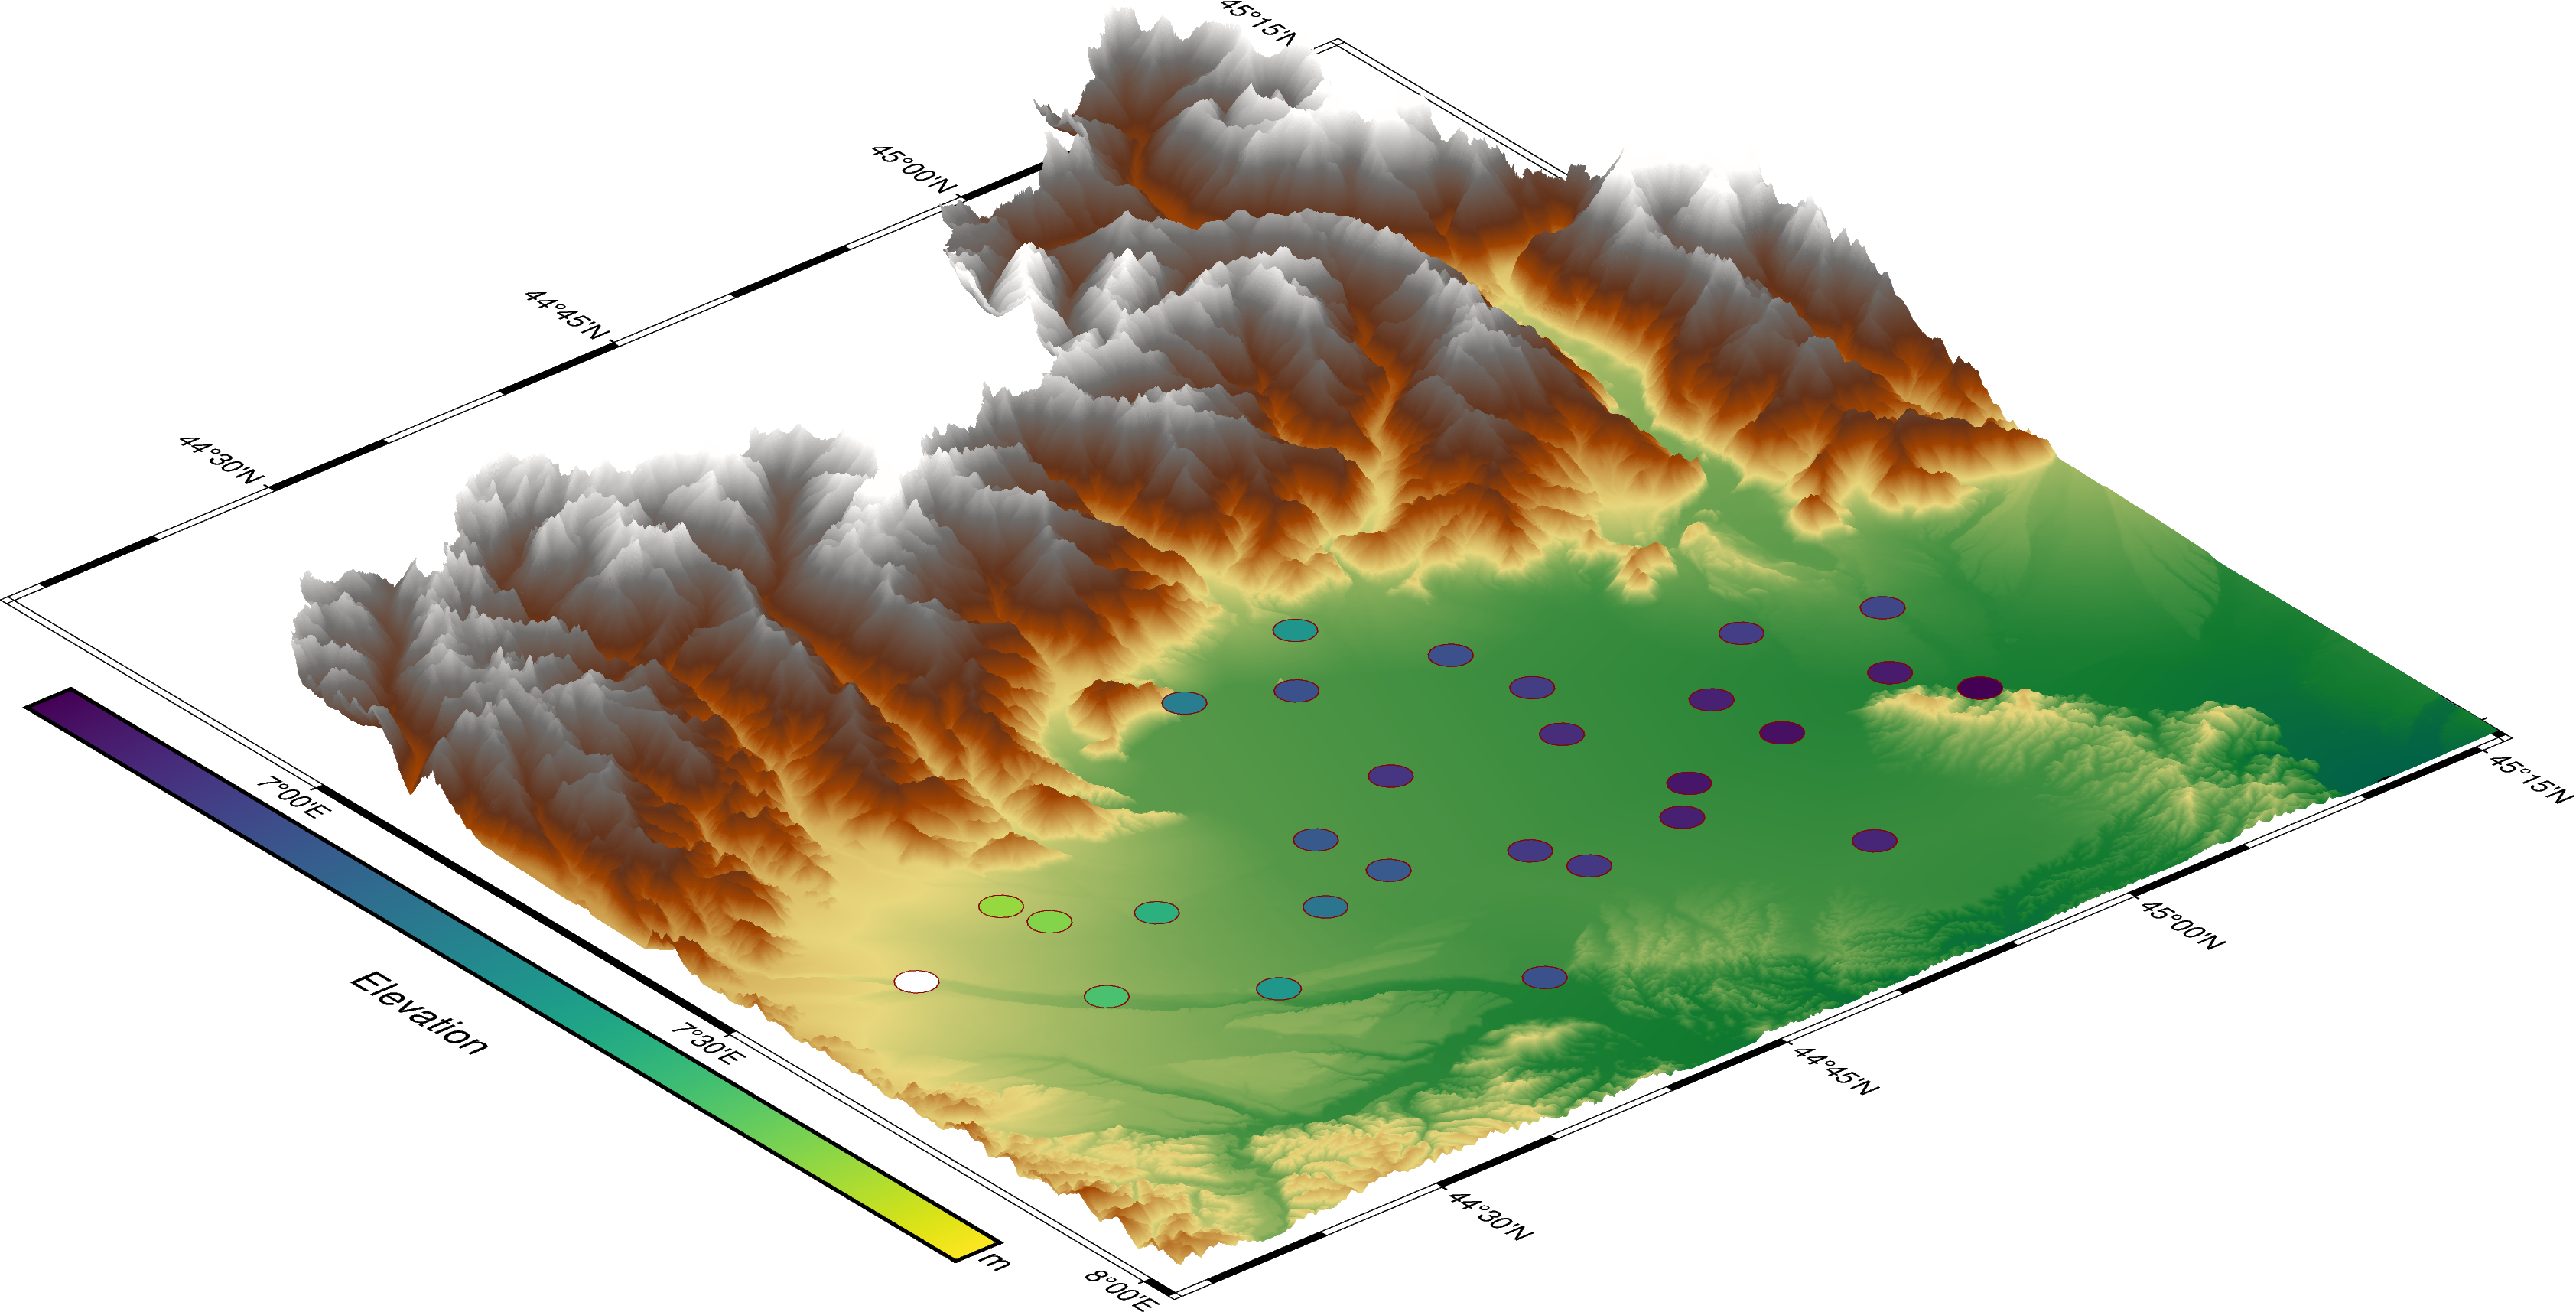

In [ ]:
fig = pygmt.Figure()
fig.grdview(
    grid=piemonte_dtm_clipped,
    perspective=[130, 30, 40],
    frame=["xa", "yaf", "WSnE"],
    projection="M20c",
    zsize="2c",
    # Set the surftype to "surface"
    surftype="s",
    # Set the CPT to "geo"
    cmap="geo",
    # Set the plane elevation to 1,000 meters and make the fill "gray"
    # plane="0+ggray",
    # Set the contour pen thickness to "0.1p"
    #contourpen="0.1p"
)

fig.colorbar(perspective=True, frame=["a500", "x+lElevation", "y+lm"])

pygmt.makecpt(cmap=cmr.get_sub_cmap(plt.cm.Blues, 0.3,1), series=[ds.wtd_geodf["means"].min(), ds.wtd_geodf["means"].max()])

fig.plot(x=ds.wtd_geodf.geometry.x,
         y=ds.wtd_geodf.geometry.y,
        fill=ds.wtd_geodf["means"],
        cmap=True,
        perspective=[130, 30, 40], projection="M20c",
        style="c0.5c", pen="darkred")




fig.show()

## Error map plots

In [21]:
import copy

In [22]:
metric_path = "C:/Users/msali/Desktop/Python/water-pinns/results/metrics"
model_id = ["STNet","STDisNet","STDisNetPI","STDisNetPI-RCH"]
metric_list = ["mape","kge"]
postfix = "_iter_pred"

In [26]:
gw_geodict = {f"{metric}": copy.deepcopy(ds.wtd_geodf.loc[:,["sensor_id","munic","geometry","means"]]) for metric in metric_list}
gw_geodict_min = {f"{metric}":1 for metric in metric_list}
gw_geodict_max = {f"{metric}":0 for metric in metric_list}

gw_geodict_iter_pred = {f"{metric}": copy.deepcopy(ds.wtd_geodf.loc[:,["sensor_id","munic","geometry","means"]]) for metric in metric_list}
gw_geodict_min_iter_pred = {f"{metric}":1 for metric in metric_list}
gw_geodict_max_iter_pred = {f"{metric}":0 for metric in metric_list}


In [27]:
# true lag
postfix = ""
for metric in metric_list:
    for model in model_id:
        metrics_ds = pd.read_csv(f"{metric_path}/{model}{postfix}_{metric}.csv",
        dtype={0: str}).rename(columns={"0":f"{model}{postfix}",
                                    "Unnamed: 0":"sensor_id"})
        
        # if metric == "mape":
        #     metrics_ds[f"{model}{postfix}"] = metrics_ds[f"{model}{postfix}"]*100
        
        if gw_geodict_min[metric]>metrics_ds[f"{model}{postfix}"].min():
            gw_geodict_min[metric] = metrics_ds[f"{model}{postfix}"].min()
            
        if gw_geodict_max[metric]<metrics_ds[f"{model}{postfix}"].max():
            gw_geodict_max[metric] = metrics_ds[f"{model}{postfix}"].max()
    
        gw_geodict[metric] = pd.merge(gw_geodict[metric],
        metrics_ds,
        on="sensor_id",
        how="inner")
    
# iter pred
postfix = "_iter_pred"
for metric in metric_list:
    for model in model_id:
        metrics_ds = pd.read_csv(f"{metric_path}/{model}{postfix}_{metric}.csv",
        dtype={0: str}).rename(columns={"0":f"{model}{postfix}",
                                    "Unnamed: 0":"sensor_id"})
        # if metric == "mape":
        #     metrics_ds[f"{model}{postfix}"] = metrics_ds[f"{model}{postfix}"]*100
            
        if gw_geodict_min_iter_pred[metric]>metrics_ds[f"{model}{postfix}"].min():
            gw_geodict_min_iter_pred[metric] = metrics_ds[f"{model}{postfix}"].min()
            
        if gw_geodict_max_iter_pred[metric]<metrics_ds[f"{model}{postfix}"].max():
            gw_geodict_max_iter_pred[metric] = metrics_ds[f"{model}{postfix}"].max()
    
        gw_geodict_iter_pred[metric] = pd.merge(gw_geodict_iter_pred[metric],
        metrics_ds,
        on="sensor_id",
        how="inner")

[]

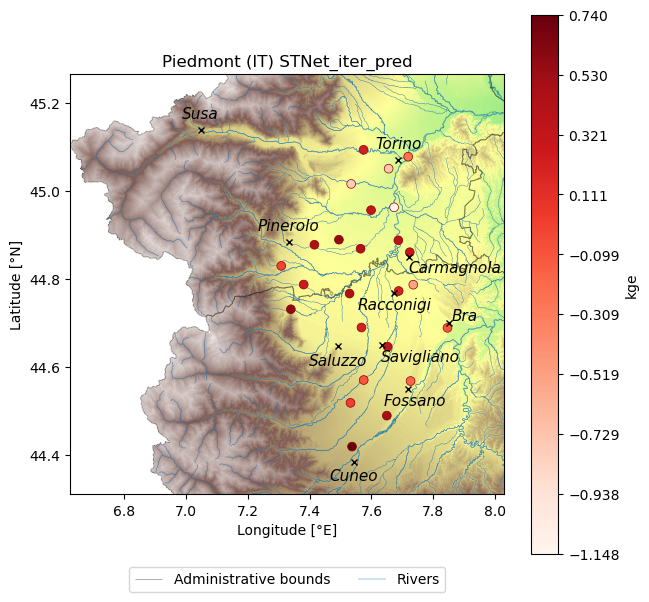

In [31]:
iter_pred = True
metric = "kge"
model = model_id[0]
geodict = gw_geodict_iter_pred if iter_pred == True else gw_geodict
model_name = model + "_iter_pred" if iter_pred == True else ""
gw_ds = geodict[metric]


fig, ax = plt.subplots(figsize = (7,7))

# Plot with lognorm transformation
piemonte_elevation = piemonte_dtm_clipped.plot(ax = ax, add_colorbar=False,
                                    cmap = cmr.get_sub_cmap(plt.cm.terrain, 0.25,1),
                                    norm = matplotlib.colors.LogNorm(vmin = piemonte_dtm.min().values,
                                    vmax = piemonte_dtm.max().values))
ax.set_title(f"Piedmont (IT) {model_name}")
ax.set_xlabel("Longitude [°E]")
ax.set_ylabel("Latitude [°N]")

# Regional shapefile
ds.piemonte_shp.boundary.plot(color = 'Black', linewidth = 0.75, alpha = 0.3, ax = ax, label = "Administrative bounds")

# Rivers
rivers_shp_100.loc[rivers_shp_100["CLASSE"] == 1].plot(ax = ax, linewidth=0.3, label = "Rivers")

# City Labels
for city, (lon, lat,(dx,dy)) in city_coords.items():
    ax.plot(lon, lat, marker="x", color='black', markersize=4, zorder=2000)  # add point
    ax.text(lon + dx, lat + dy, city, fontsize=11,
        ha='center',
        va='bottom',
        fontstyle = "italic",
        color='black', zorder=2000)

# Sensors
gw_points = ax.scatter(
    gw_ds.geometry.x, gw_ds.geometry.y,
    marker="o",
    c=gw_ds[model_name],
    cmap="Reds",
    edgecolor='darkred',
    linewidths = 0.5,
    zorder = 1000,
    s=40)

plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.25), ncol=len(plt.gca().get_legend_handles_labels()[0]))

# Colorbar for points
ticks_h = np.linspace(gw_ds[model_name].min(), gw_ds[model_name].max(),10)
plt.colorbar(mappable = gw_points, ticks= ticks_h, label = metric)

#plt.savefig(f"{save_plot_dir}/map_{metric}_{model_name}.png", dpi = 400, transparent = True, bbox_inches = 'tight')

plt.plot()

In [28]:
from matplotlib.ticker import FormatStrFormatter

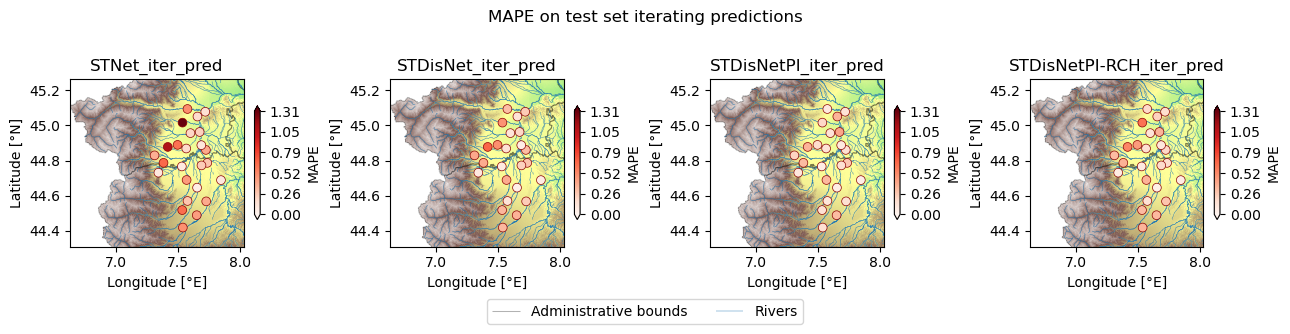

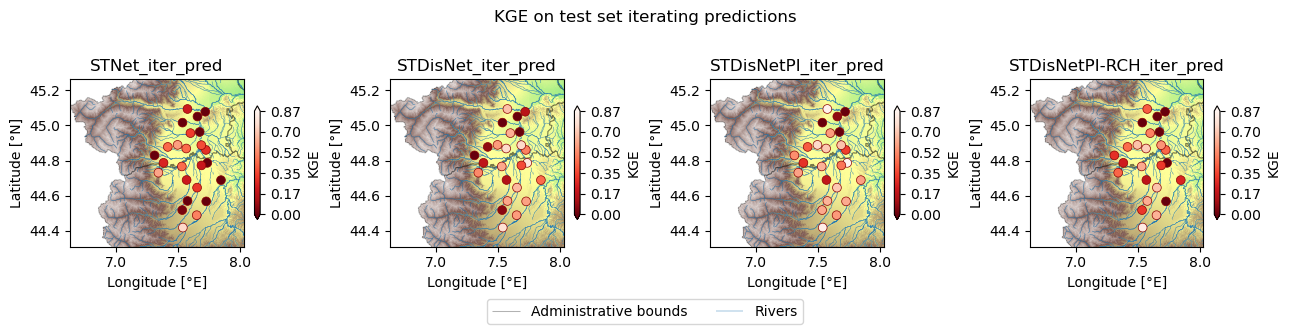

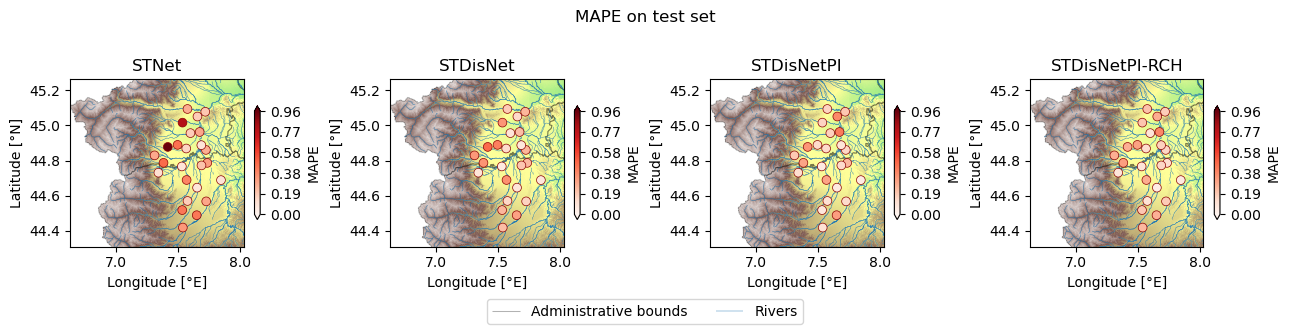

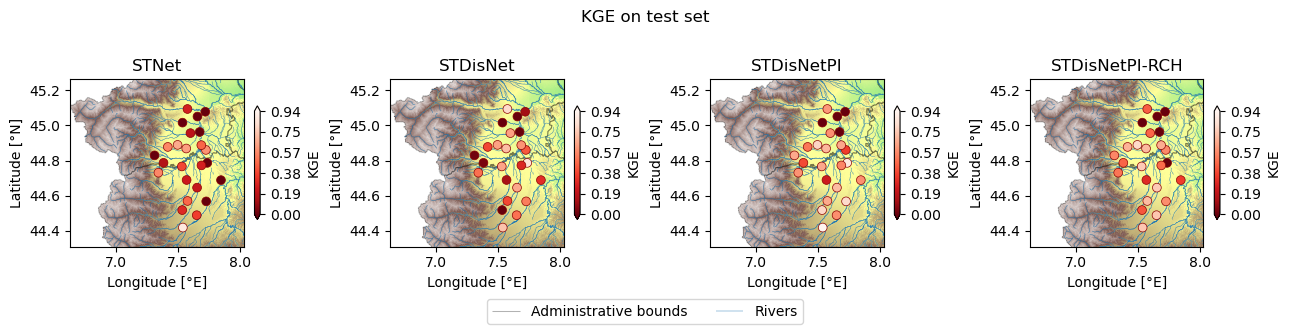

In [29]:
iter_pred = False
metric = "mape"
for iter_pred in [True, False]:
    for metric in metric_list:
        geodict = gw_geodict_iter_pred if iter_pred is True else gw_geodict
        min_dict = gw_geodict_min_iter_pred if iter_pred is True else gw_geodict_min
        max_dict = gw_geodict_max_iter_pred if iter_pred is True else gw_geodict_max
        
        gw_ds = geodict[metric]

        fig, ax = plt.subplots(1,4, figsize = (13,3))
        title = f"{metric.upper()} on test set"
        title +=" iterating predictions" if iter_pred is True else ""
        fig.suptitle(title)

        for i in range(4):
            # Select the model
            model = model_id[i]
            model_name = model
            model_name += "_iter_pred" if iter_pred is True else ""
            
            # Plot with lognorm transformation
            piemonte_elevation = piemonte_dtm_clipped.plot(ax = ax[i], add_colorbar=False,
                                                cmap = cmr.get_sub_cmap(plt.cm.terrain, 0.25,1),
                                                norm = matplotlib.colors.LogNorm(vmin = piemonte_dtm.min().values,
                                                vmax = piemonte_dtm.max().values))
            ax[i].set_title(f"{model_name}")
            ax[i].set_xlabel("Longitude [°E]")
            ax[i].set_ylabel("Latitude [°N]")

            # Regional shapefile
            ds.piemonte_shp.boundary.plot(color = 'Black',
                                        linewidth = 0.75,
                                        alpha = 0.3,
                                        ax = ax[i],
                                        label = "Administrative bounds")

            # Rivers
            rivers_shp_100.loc[rivers_shp_100["CLASSE"] == 1].plot(ax = ax[i], 
                                                                linewidth=0.3,
                                                                label = "Rivers")

            # # City Labels
            # for city, (lon, lat,(dx,dy)) in city_coords.items():
            #     ax[i].plot(lon, lat, marker="x", color='black', markersize=4, zorder=2000)  # add point
            #     ax[i].text(lon + dx, lat + dy, city, fontsize=10,
            #         ha='center',
            #         va='bottom',
            #         fontstyle = "italic",
            #         color='black', zorder=2000)

            # Sensors
            gw_points = ax[i].scatter(
                gw_ds.geometry.x, gw_ds.geometry.y,
                marker="o",
                c=gw_ds[model_name],
                cmap="Reds" if metric == "mape" else "Reds_r",
                edgecolor='darkred',
                linewidths = 0.5,
                zorder = 1000,
                vmin = 0,
                vmax = max_dict[metric],
                s=40)
            
            # Colorbar for points
            ticks = np.linspace(0, max_dict[metric],6)
            cbar = plt.colorbar(mappable = gw_points, ticks= ticks, label = metric.upper(), ax = ax[i], shrink = 0.5,
                        extend = "both")
            cbar.ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))


        # Get handles/labels from the first subplot
        handles, labels = ax[0].get_legend_handles_labels()

        # Put one shared legend below all subplots
        fig.legend(
            handles, labels,
            loc="lower center",
            bbox_to_anchor=(0.5,-0.09),  # center bottom, slightly outside
            ncol=len(labels)              # all labels in one row
        )
            
        #plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.25))

        save_name = f"{save_plot_dir}/map_{metric.upper()}"
        save_name += "_iter_pred" if iter_pred is True else ""

        plt.tight_layout(h_pad=0, w_pad=0.7)

        plt.savefig(f"{save_name}.png", dpi = 400, transparent = True, bbox_inches = 'tight')

# Time Series

## NA stats

In [32]:
ds.wtd_df

wtd       lat       lon    height         h  \
date       sensor_id                                                        
2000-12-31 00103510001        NaN  0.092573 -0.154837 -0.867314       NaN   
           00104110001        NaN  0.244253  0.092673 -0.951665       NaN   
           00105110001        NaN  0.492360  0.515847 -1.021644       NaN   
           00105910001        NaN  0.190429  0.804935 -1.019226       NaN   
           00105910002        NaN  0.275844  0.719558 -1.028665       NaN   
...                           ...       ...       ...       ...       ...   
2023-12-24 00417910001   5.068571 -0.087850  0.722069 -0.997676 -0.614138   
           00421510001   3.931905 -0.487574  0.639993 -0.930317  0.213099   
           00421710001   6.553762 -0.349954  0.444199 -0.962435 -0.209684   
           00422510001  26.085667 -0.890702  0.362317 -0.777576  1.751913   
           00425010001   4.953333 -0.726844  0.461141 -0.853104  1.129672   

                             doy_sin   doy_cos  
date       sensor_id                            
2000-12-31 00103510001 -2.449294e-16  1.000000  
           00104110001 -2.449294e-16  1.000000  
           00105110001 -2.449294e-16  1.000000  
           00105910001 -2.449294e-16  1.000000  
           00105910002 -2.449294e-16  1.000000  
...                              ...       ...  
2023-12-24 00417910001 -1.369061e-01  0.990584  
           00421510001 -1.369061e-01  0.990584  
           00421710001 -1.369061e-01  0.990584  
           00422510001 -1.369061e-01  0.990584  
           00425010001 -1.369061e-01  0.990584  

[33600 rows x 7 columns]

In [33]:
gw_ns_perc = ds.wtd_df["h"].isna().groupby(level='sensor_id').sum()/ds.wtd_df.index.get_level_values(0).unique().size
gw_ns_perc.name = "perc_missing"

In [34]:
gw_ns_perc

sensor_id
00103510001    0.116667
00104110001    0.377500
00105110001    0.394167
00105910001    0.035000
00105910002    0.083333
00107010001    0.220000
00109010001    0.205833
00112710001    0.235000
00117110001    0.308333
00119710001    0.769167
00126010001    0.043333
00127210001    0.047500
00127210003    0.360833
00131010001    0.325000
00401210001    0.005833
00402910001    0.225833
00403410001    0.249167
00404110001    0.535833
00405910001    0.311667
00407810001    0.098333
00408910001    0.144167
00408910002    0.210000
00414310002    0.130833
00417910001    0.058333
00421510001    0.218333
00421710001    0.318333
00422510001    0.059167
00425010001    0.267500
Name: perc_missing, dtype: float64

In [53]:
missing_table = pd.merge(ds.wtd_geodf.loc[:,["munic","sensor_id","means","stds"]],gw_ns_perc, on = "sensor_id")
missing_table

munic    sensor_id       means      stds  perc_missing
0          Bricherasio  00103510001  348.223319  0.746453      0.116667
1             Buriasco  00104110001  274.182948  1.794716      0.377500
2             Candiolo  00105110001  232.811733  0.513118      0.394167
3           Carmagnola  00105910001  231.892891  0.812636      0.035000
4           Carmagnola  00105910002  223.767643  0.403061      0.083333
5               Cavour  00107010001  274.777412  1.841884      0.220000
6             Collegno  00109010001  265.222574  1.114240      0.205833
7            La Loggia  00112710001  219.357687  0.441174      0.235000
8            Orbassano  00117110001  257.016697  1.787895      0.308333
9              Poirino  00119710001  237.157322  0.543899      0.769167
10           Scalenghe  00126010001  256.419434  1.060704      0.043333
11              Torino  00127210001  227.730461  0.563786      0.047500
12              Torino  00127210003  208.769801  0.358943      0.360833
13      Virle Piemonte  00131010001  241.876652  0.584563      0.325000
14               Barge  00401210001  321.578714  0.487901      0.005833
15                 Bra  00402910001  275.201830  0.341377      0.225833
16               Busca  00403410001  434.675778  1.861772      0.249167
17  Caramagna Piemonte  00404110001  251.497692  0.488039      0.535833
18    Cavallermaggiore  00405910001  282.773736  0.500921      0.311667
19               Cuneo  00407810001  476.663036  1.855939      0.098333
20             Fossano  00408910001  351.208899  0.485459      0.144167
21             Fossano  00408910002  399.366819  1.211869      0.210000
22             Moretta  00414310002  249.210762  0.347753      0.130833
23           Racconigi  00417910001  252.498451  0.744324      0.058333
24          Savigliano  00421510001  312.866278  0.265856      0.218333
25          Scarnafigi  00421710001  282.321126  1.169114      0.318333
26          Tarantasca  00422510001  427.368403  1.440956      0.059167
27         Vottignasco  00425010001  380.387208  0.834027      0.267500

In [54]:
missing_table.to_csv(f"{save_dir}/missing_table.csv")

In [55]:
import seaborn as sns

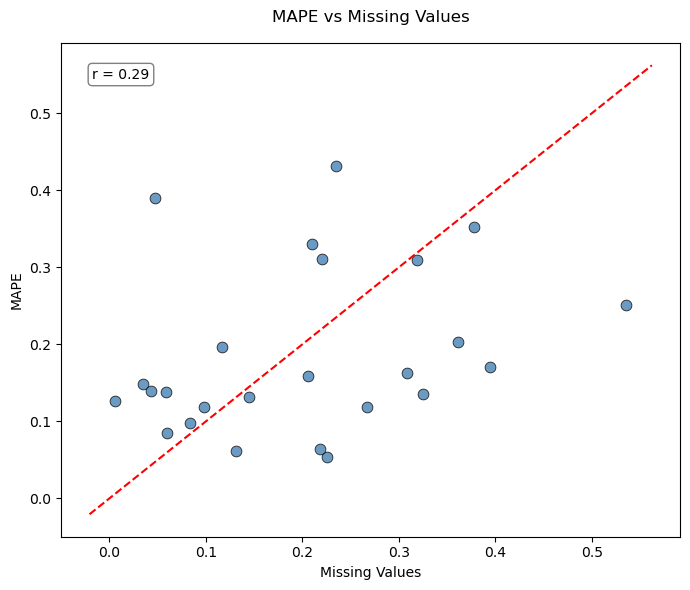

In [56]:
corr_ds = pd.merge(gw_geodict["mape"][["sensor_id","STDisNetPI"]],
          gw_ns_perc, on ="sensor_id")

corr = corr_ds.loc[:,["STDisNetPI","perc_missing"]].corr().iloc[1,0]
corr

plt.figure(figsize=(7, 6))
#sns.set_style("whitegrid")

# Scatter points
sns.scatterplot(
    data=corr_ds,
    x="perc_missing",
    y="STDisNetPI",
    s=60,
    color="steelblue",
    edgecolor="black",
    alpha=0.8
)

# --- 3️⃣ Add 1:1 bisector ---
lims = [
    np.min([plt.xlim(), plt.ylim()]),  # min of both axes
    np.max([plt.xlim(), plt.ylim()])   # max of both axes
]
plt.plot(lims, lims, '--', color='red', lw=1.5)

# --- 4️⃣ Add correlation annotation ---
plt.text(
    0.05, 0.95,
    f"r = {corr:.2f}",
    transform=plt.gca().transAxes,
    verticalalignment='top',
    bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3')
)

# --- 5️⃣ Final touches ---
plt.xlabel("Missing Values")
plt.ylabel("MAPE")
plt.title("MAPE vs Missing Values", pad=15)
plt.tight_layout()
plt.savefig(f"{save_plot_dir}/MAPE_vs_NA.png", dpi = 400, transparent = True, bbox_inches = 'tight')
plt.show()

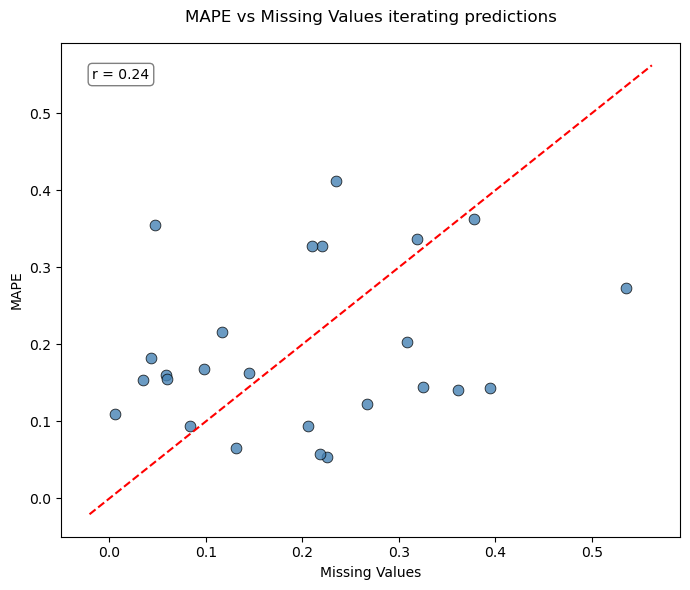

In [57]:
corr_ds = pd.merge(gw_geodict_iter_pred["mape"][["sensor_id","STDisNetPI_iter_pred"]],
          gw_ns_perc, on ="sensor_id")

corr = corr_ds.loc[:,["STDisNetPI_iter_pred","perc_missing"]].corr().iloc[1,0]
corr

plt.figure(figsize=(7, 6))
#sns.set_style("whitegrid")

# Scatter points
sns.scatterplot(
    data=corr_ds,
    x="perc_missing",
    y="STDisNetPI_iter_pred",
    s=60,
    color="steelblue",
    edgecolor="black",
    alpha=0.8
)

# --- 3️⃣ Add 1:1 bisector ---
lims = [
    np.min([plt.xlim(), plt.ylim()]),  # min of both axes
    np.max([plt.xlim(), plt.ylim()])   # max of both axes
]
plt.plot(lims, lims, '--', color='red', lw=1.5)

# --- 4️⃣ Add correlation annotation ---
plt.text(
    0.05, 0.95,
    f"r = {corr:.2f}",
    transform=plt.gca().transAxes,
    verticalalignment='top',
    bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3')
)

# --- 5️⃣ Final touches ---
plt.xlabel("Missing Values")
plt.ylabel("MAPE")
plt.title("MAPE vs Missing Values iterating predictions", pad=15)
plt.tight_layout()
plt.savefig(f"{save_plot_dir}/MAPE_vs_NA_iter_pred.png", dpi = 400, transparent = True, bbox_inches = 'tight')
plt.show()

## Plots

C:\Users\msali\AppData\Local\Temp\ipykernel_17036\2780761470.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize = (13,3))


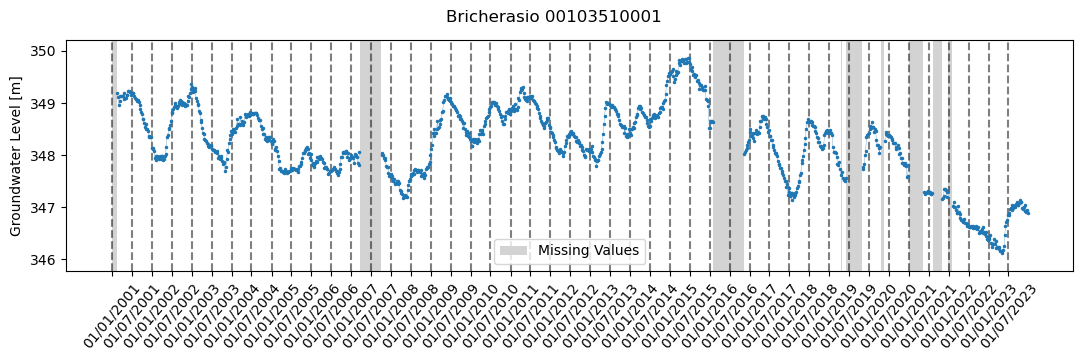

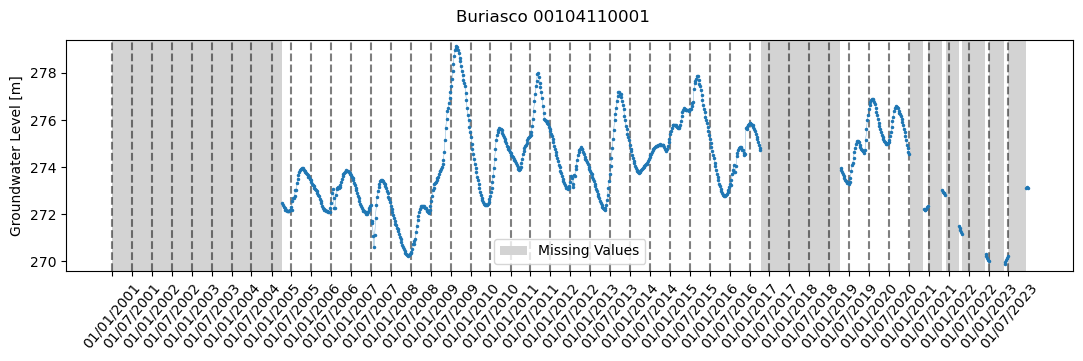

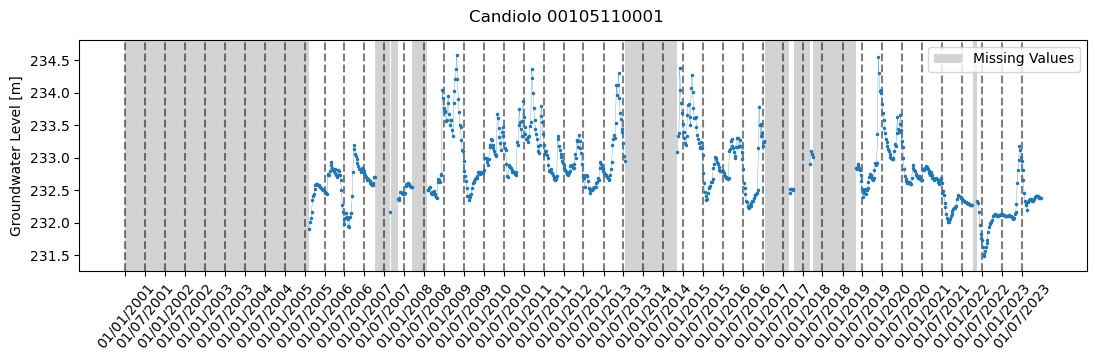

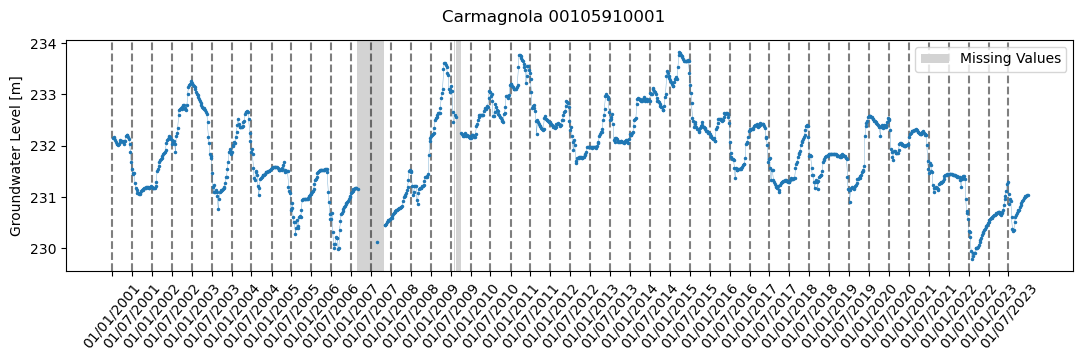

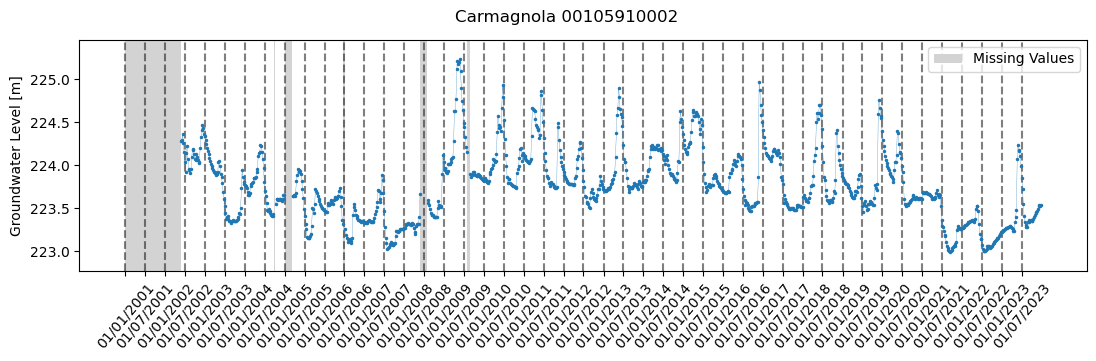

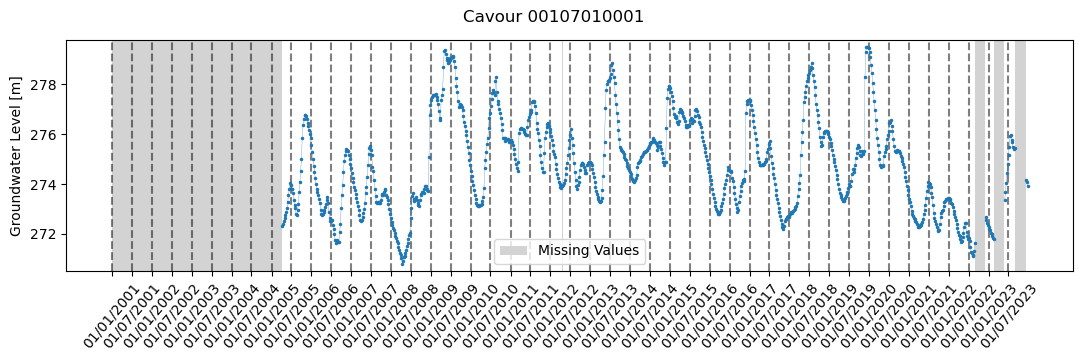

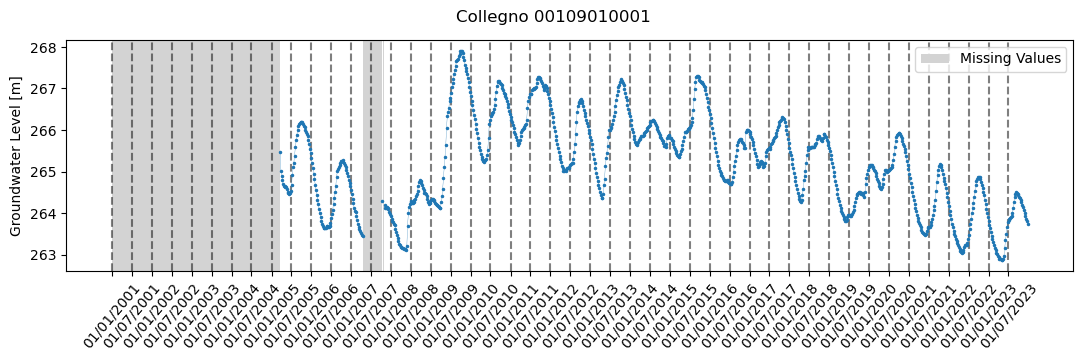

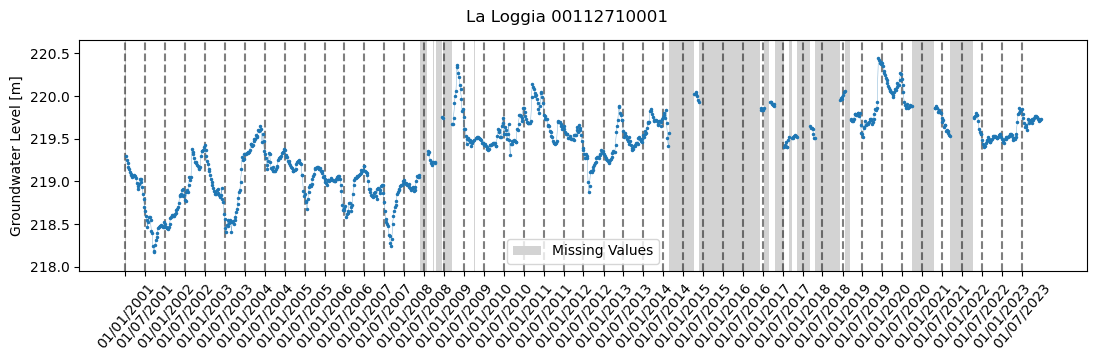

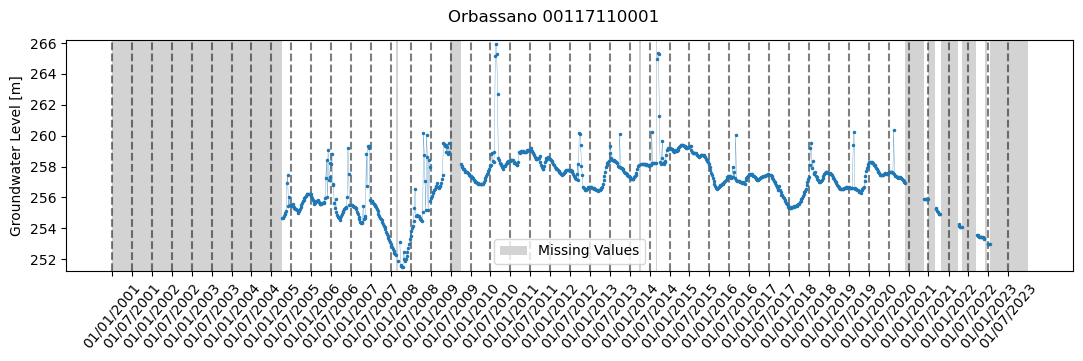

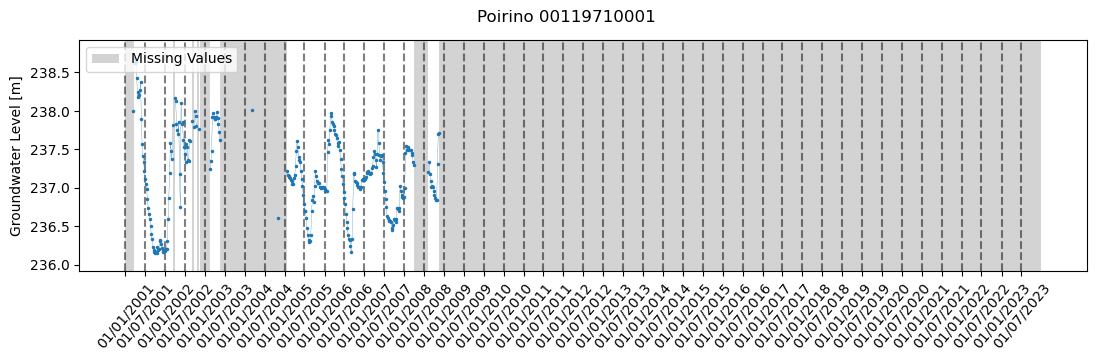

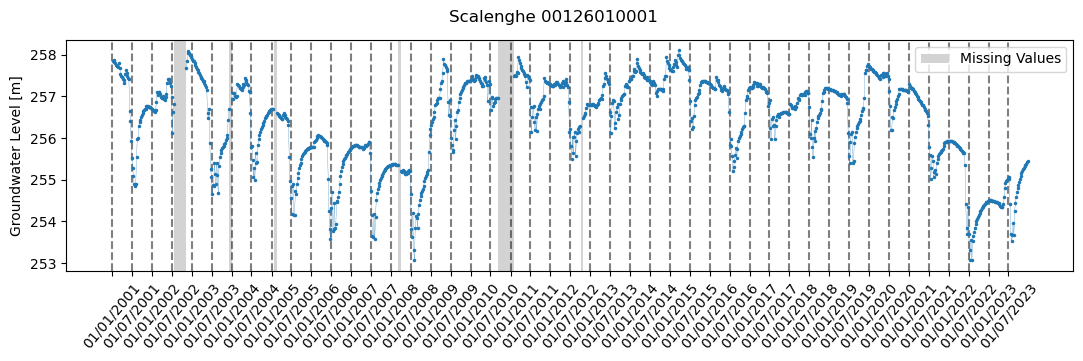

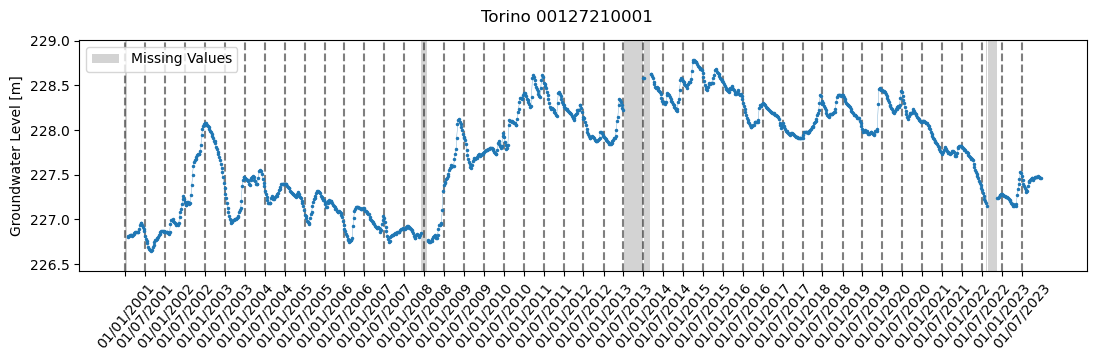

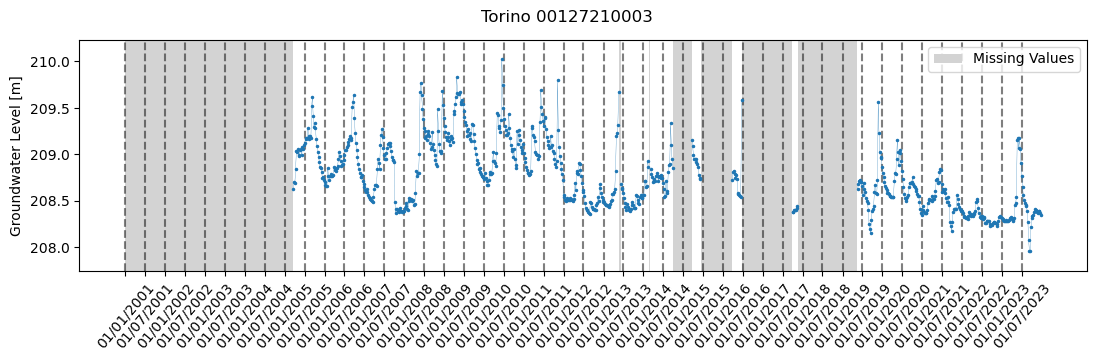

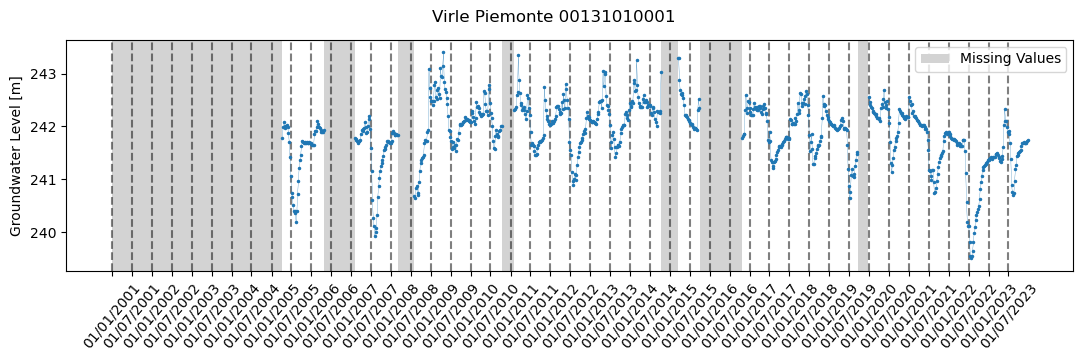

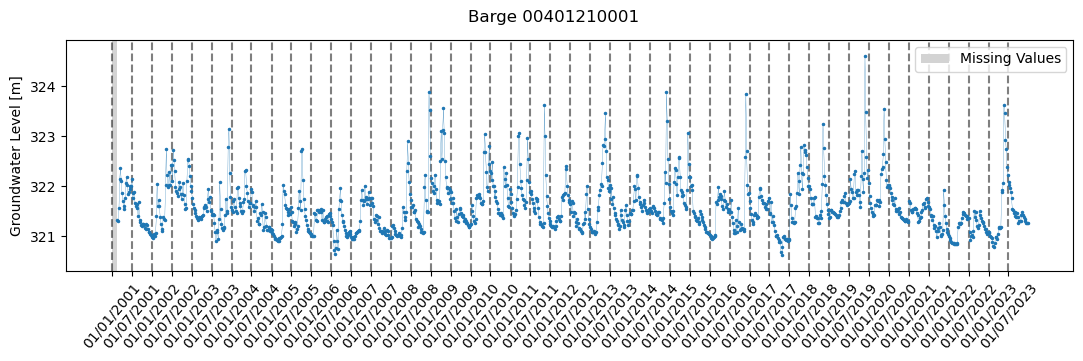

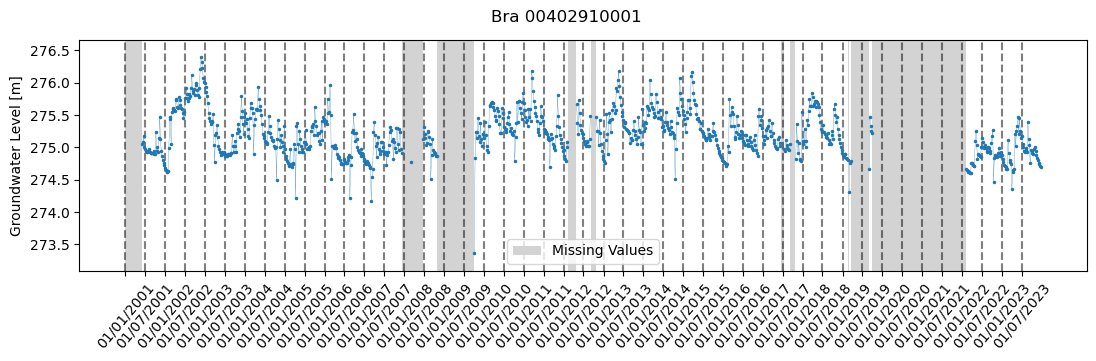

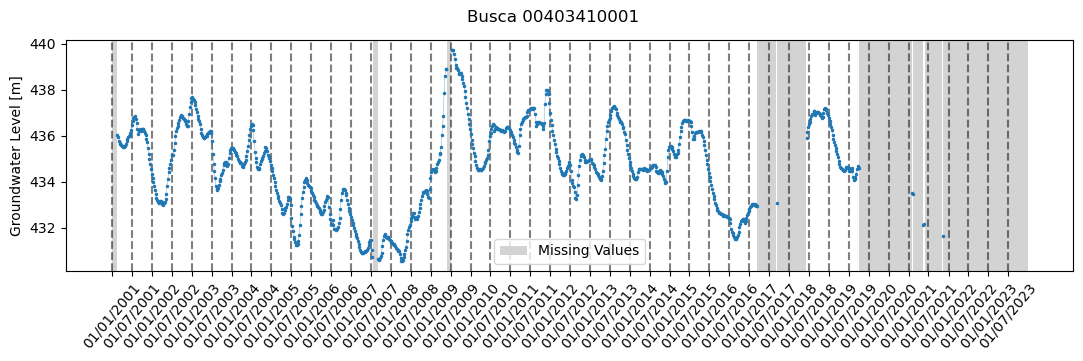

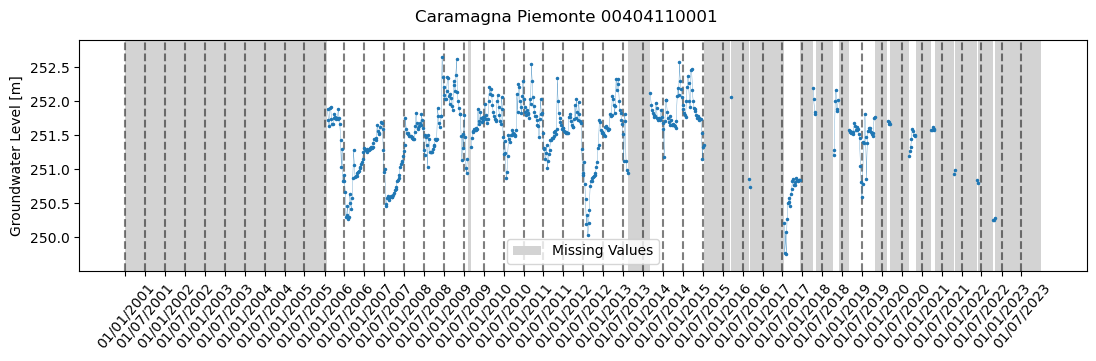

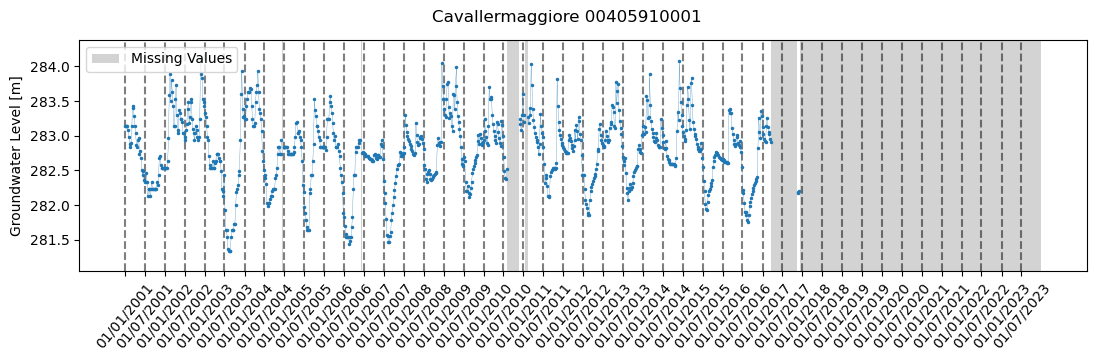

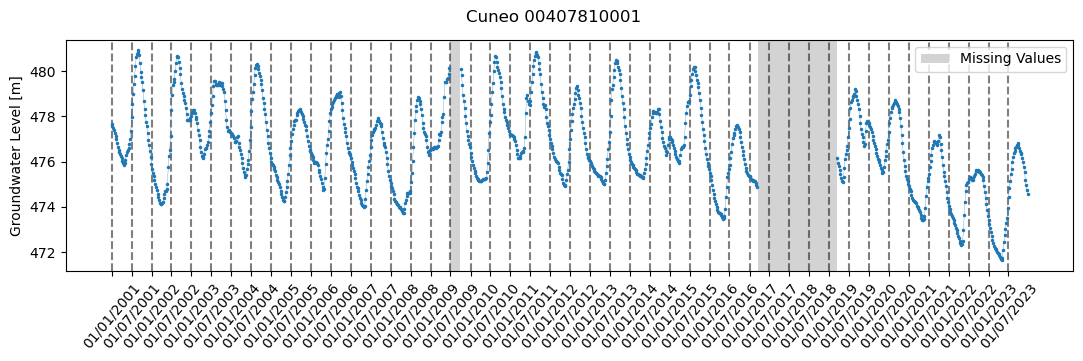

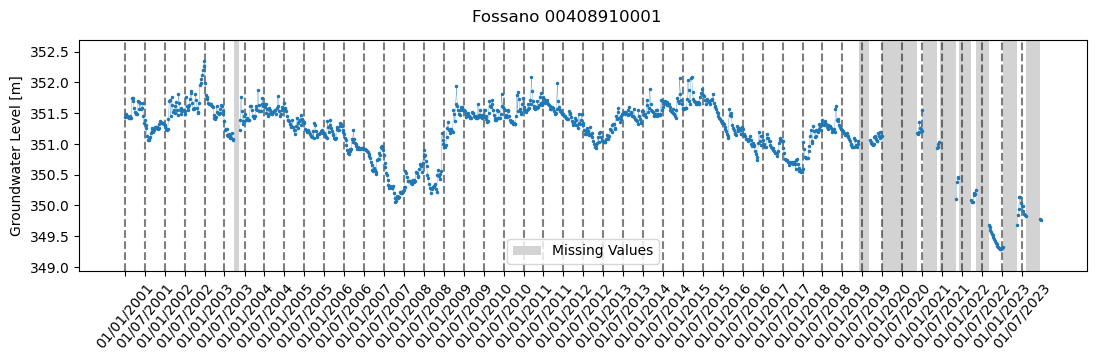

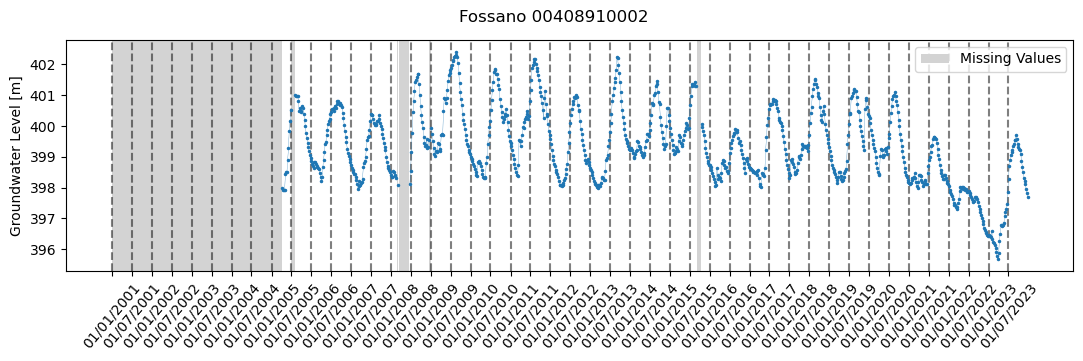

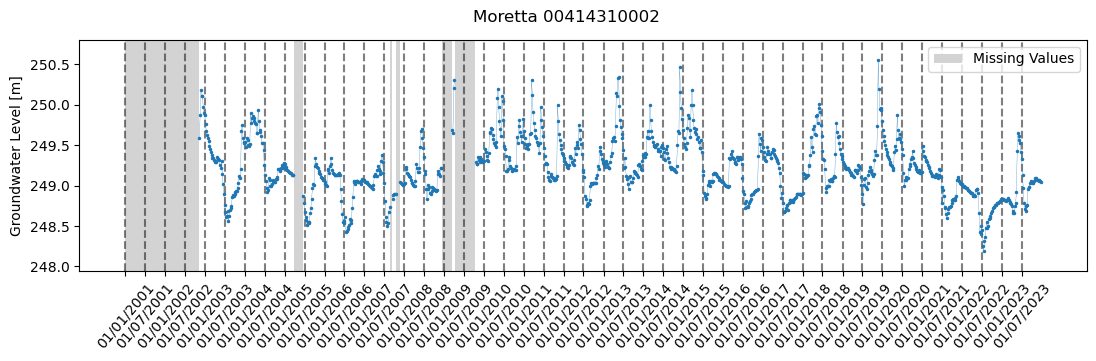

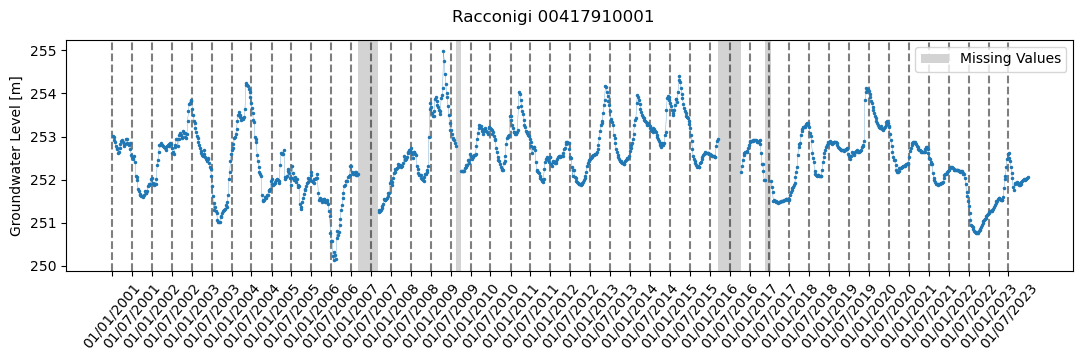

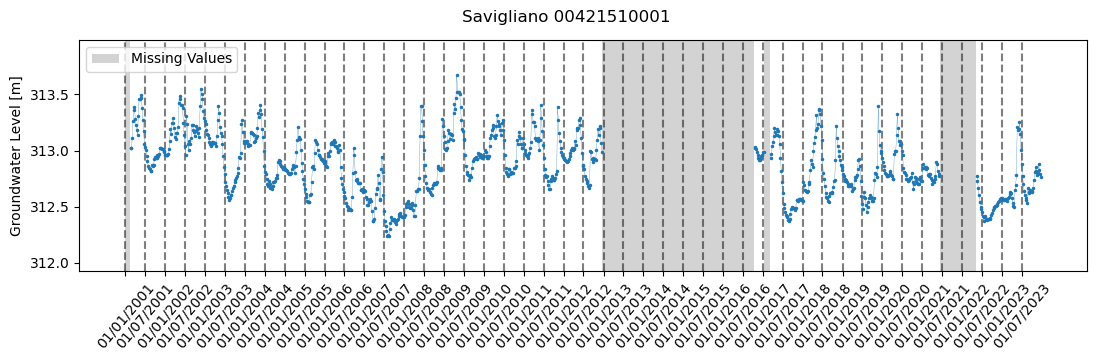

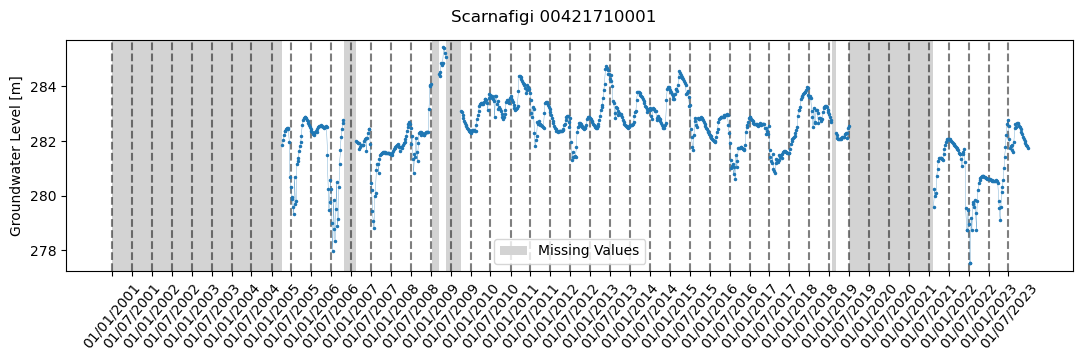

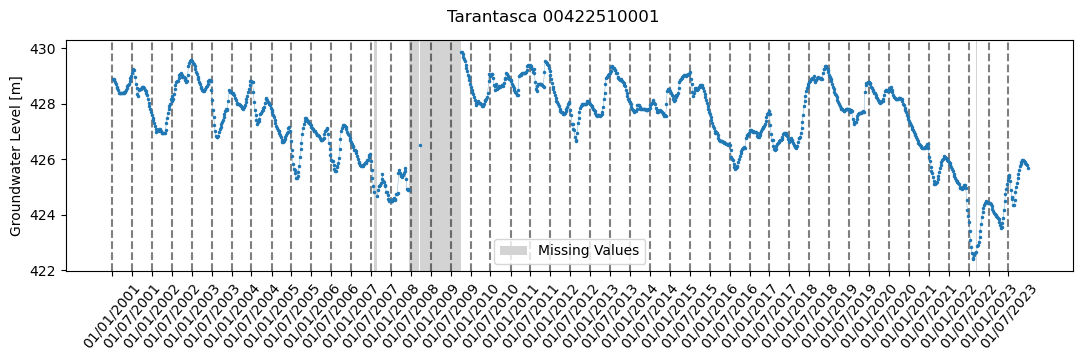

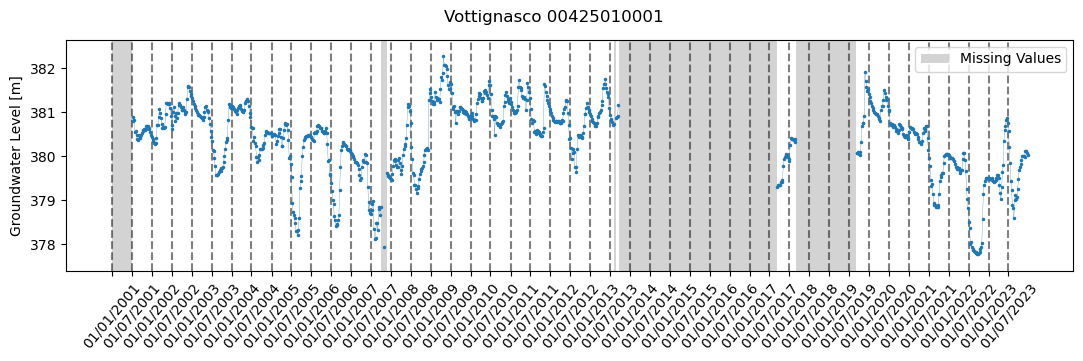

In [64]:
weekly_sensor_list = ds.sensor_id_list
for sensor_idx in range(len(weekly_sensor_list)):
        
    sensor_series = ds.wtd_df["h"].loc[pd.IndexSlice[:, weekly_sensor_list[sensor_idx]]]
    
    # denorm
    sensor_series = (sensor_series * ds.norm_factors["target_stds"]) + ds.norm_factors["target_means"]
    
    sensor_series_dates = sensor_series.index.get_level_values(0)
    
    municipality = ds.wtd_geodf.loc[ds.wtd_geodf["sensor_id"] == weekly_sensor_list[sensor_idx],
                                "munic"].values[0]
    
    fig, ax = plt.subplots(figsize = (13,3))
    
    fig.suptitle(f"{municipality} {weekly_sensor_list[sensor_idx]}")
    
    ax.plot(sensor_series_dates,
        sensor_series.values, 
        marker = "o",
        lw = 0.2,
        markersize = 1.5)
    
    ax.set_ylabel("Groundwater Level [m]")
    
    date_xticks = pd.date_range(np.datetime64("2001-01-01"), np.datetime64("2023-12-31"), freq = "6MS",  normalize = True, inclusive = "both")
    
    ax.set_ylim([sensor_series.min() - sensor_series.min()*0.001,
                sensor_series.max() + sensor_series.min()*0.001])
    
    ax.bar(sensor_series_dates[sensor_series.isnull()],
                bottom = ax.get_ylim()[0],
                height = ax.get_ylim()[1],
                width= 7,
                align='center',
                color = 'lightgrey',
                #alpha = 0.4,
                label = "Missing Values", zorder = 0)
    
    ax.set_xticks(date_xticks, date_xticks.strftime('%d/%m/%Y'))
    ax.tick_params(axis = "x", rotation=50 )
    
    ax.legend()#bbox_to_anchor =(0.5,-0.2), loc = 'lower center'

    ax.grid(axis="x", ls = "--", which = "both", lw = "1.5", color = 'black', alpha = 0.5)
    
    plt.savefig(f"{save_ts_dir}/{municipality}_{weekly_sensor_list[sensor_idx]}_ts.png", dpi = 400, transparent = True, bbox_inches = 'tight')
    
    #linestyle = '--', axis = 'x', color = 'black', alpha = 0.5